# Checking test functionality


In [ ]:
# import pandas as pd
from pathlib import Path
from rasterio.plot import show
from ftw_ma import *

Test is already integrated in the compiler, and runs from the CLI.  However, the object-level metrics might not be valid, so we want to test these.  

Using a check that write out masks and labels to pngs for visual inspection, let's work through ftw's object level precision function and see what is happening. 

In [9]:
output_dir = "~/models/unet-effb3-ce-noaug"
masks = []
preds = []
for i in range(0, 8): 
    mask = Path(output_dir).expanduser() / "test_masks" / f"mask_{i}.png"
    pred = Path(output_dir).expanduser() / "test_outputs" / f"output_{i}.png"     
    masks.append(np.array(Image.open(mask)))
    preds.append( np.array(Image.open(pred)))

In [61]:
i = 2
y_true = masks[i]
y_pred = preds[i]
y_true_shapes = []
for geom, val in rasterio.features.shapes(y_true):
    if val == 1:
        y_true_shapes.append(shapely.geometry.shape(geom))

y_pred_shapes = []
for geom, val in rasterio.features.shapes(y_pred):
    if val == 1:
        y_pred_shapes.append(shapely.geometry.shape(geom))

y_true_shapes[0]
y_pred_shapes[len(y_pred_shapes)-1]

[<POLYGON ((0 221, 0 227, 1 227, 1 226, 2 226, 2 224, 3 224, 3 222, 2 222, 2 ...>,
 <POLYGON ((0 232, 0 242, 1 242, 1 241, 2 241, 2 237, 3 237, 3 234, 2 234, 2 ...>]

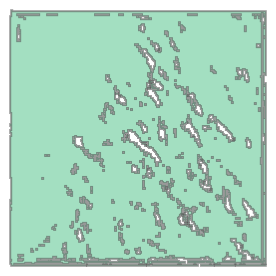

In [57]:
from shapely.geometry import shape
from shapely.ops import unary_union

# y_true_s# convert geojson-like -> shapely
polys = [shape(item["geometry"]) if isinstance(item, dict) 
         and "geometry" in item else shape(item)
         for item in y_pred_shapes]
combined = unary_union(polys) 
combined

In [59]:
iou_threshold = 0.5
tps = 0
fns = 0
tp_is = set()  # keep track of which true shapes are true positives
tp_js = set()  # keep track of which predicted shapes are true positives
fn_is = set()  # keep track of which true shapes are false negatives
matched_js = set()
for i, y_true_shape in enumerate(y_true_shapes):
    matching_j = None
    for j, y_pred_shape in enumerate(y_pred_shapes):
        if y_true_shape.intersects(y_pred_shape):
            intersection = y_true_shape.intersection(y_pred_shape)
            union = y_true_shape.union(y_pred_shape)
            iou = intersection.area / union.area
            print(iou)
            if iou > iou_threshold:
                print(f"{i}: {iou}")
                matching_j = j
                matched_js.add(j)
                tp_js.add(j)
                break
    if matching_j is not None:
        tp_is.add(i)
        tps += 1
    else:
        fn_is.add(i)
        fns += 1
fps = len(y_pred_shapes) - len(matched_js)
fp_js = (
    set(range(len(y_pred_shapes))) - matched_js
)  # compute which of the predicted shapes are false positives


0.00021612635078969243
0.00034912718204488776


In [60]:
print(fps, tps, fns)

36 0 2


This seems to be working

In [45]:
all_tps = 0
all_fps = 0
all_fns = 0
for i in range(len(masks)):
    y_true = masks[i]
    y_pred = preds[i]
    y_true_shapes = []
    for geom, val in rasterio.features.shapes(y_true):
        if val == 1:
            y_true_shapes.append(shapely.geometry.shape(geom))

    y_pred_shapes = []
    for geom, val in rasterio.features.shapes(y_pred):
        if val == 1:
            y_pred_shapes.append(shapely.geometry.shape(geom))

    tps = 0
    fns = 0
    tp_is = set()  # keep track of which true shapes are true positives
    tp_js = set()  # keep track of which predicted shapes are true positives
    fn_is = set()  # keep track of which true shapes are false negatives
    matched_js = set()
    for i, y_true_shape in enumerate(y_true_shapes):
        matching_j = None
        for j, y_pred_shape in enumerate(y_pred_shapes):
            if y_true_shape.intersects(y_pred_shape):
                intersection = y_true_shape.intersection(y_pred_shape)
                union = y_true_shape.union(y_pred_shape)
                iou = intersection.area / union.area
                # print(iou)
                if iou > iou_threshold:
                    print(f"{i}: {iou}")
                    matching_j = j
                    matched_js.add(j)
                    tp_js.add(j)
                    break
        if matching_j is not None:
            tp_is.add(i)
            tps += 1
        else:
            fn_is.add(i)
            fns += 1
    fps = len(y_pred_shapes) - len(matched_js)
    fp_js = (
        set(range(len(y_pred_shapes))) - matched_js
    )  # compute which of the predicted shapes are false positives

    all_tps += tps
    all_fps += fps
    all_fns += fns


print(all_fps, all_tps, all_fns)

1302 0 262


## Examining images from test catalog

In [2]:
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import os
import pandas as pd
import rasterio
inf_catalog = pd.read_csv("../data/ftw-ma-combined-inference-tester.csv")
imgs = []
for i, row in inf_catalog.iterrows():
    path = Path("~/data/labels/cropland") / row["window_b"]
    with rasterio.open(path.expanduser()) as src:
        img = src.read()
        print(img.min(), img.max(), src.nodata)
        imgs.append(img)
        


267 4298 65535.0
324 3494 65535.0
126 6916 None
95 4454 65535.0
123 4946 None
0 9233 None
146 6090 None
131 3142 65535.0
92 5154 None
480 3341 65535.0


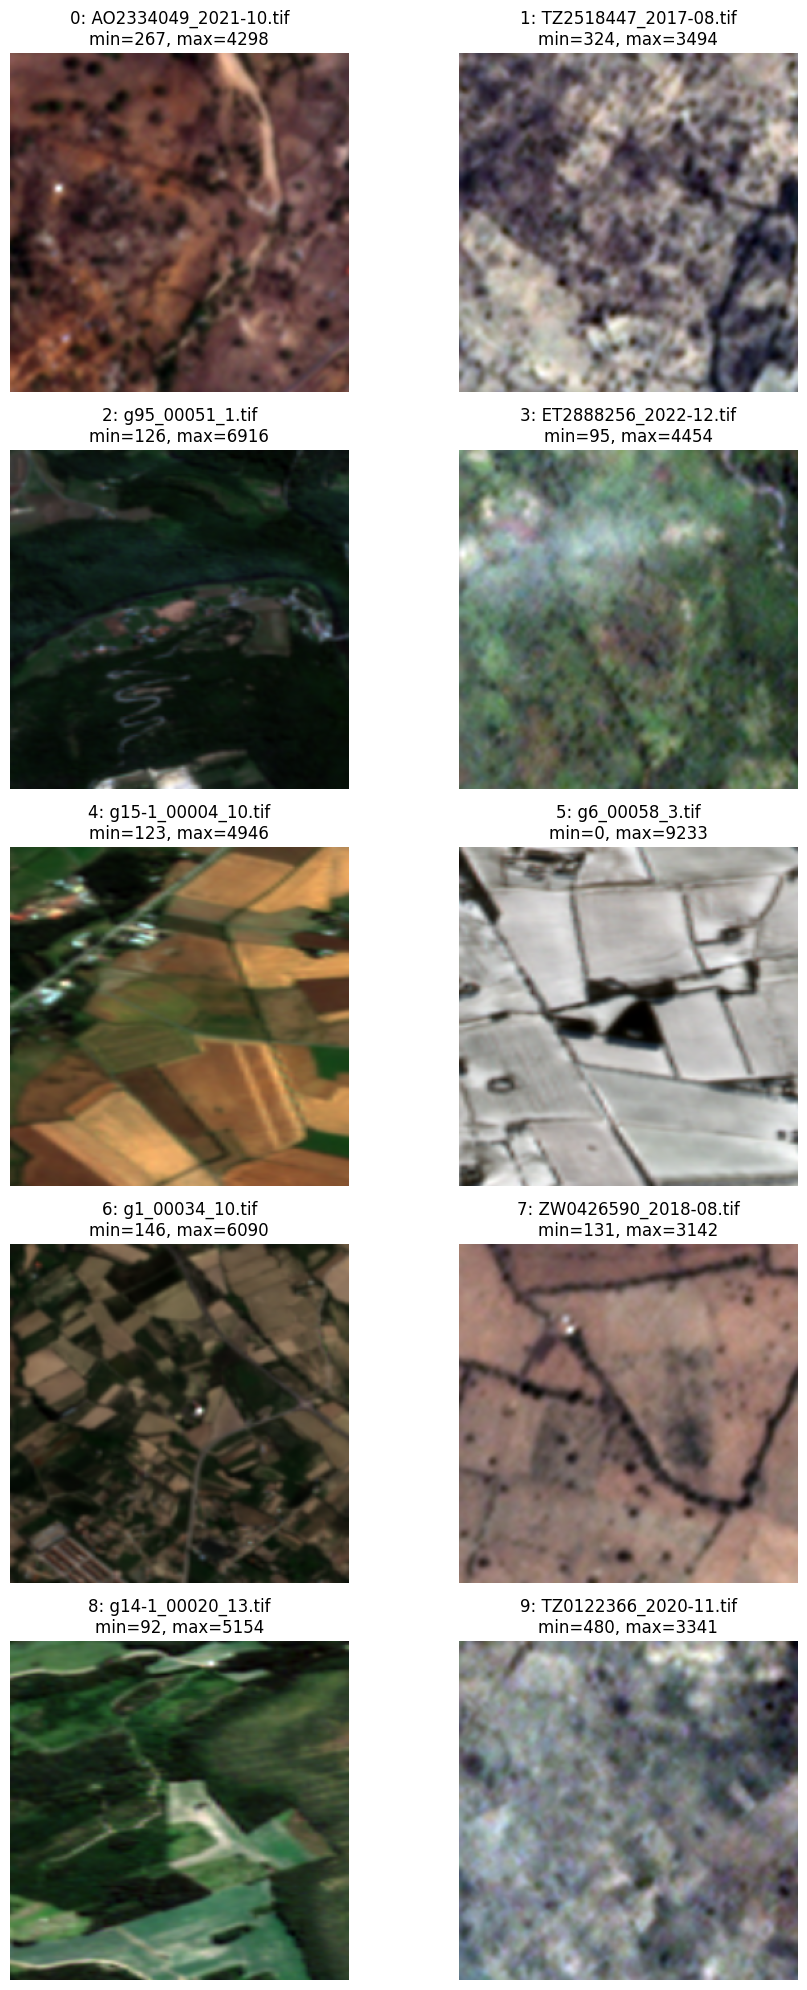

In [9]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for ax, img, row in zip(axs.ravel(), imgs, inf_catalog.itertuples()):
    # Compute per-band min and max
    mins = img.min(axis=(1, 2))
    maxs = img.max(axis=(1, 2))
    # Rescale each band
    img_rescale = np.stack([(b - mins[i]) / (maxs[i] - mins[i] + 1e-8) 
                            for i, b in enumerate(img)], axis=0)
    # Show as RGB if at least 3 bands, else show first band
    if img_rescale.shape[0] >= 3:
        ax.imshow(np.transpose(img_rescale[:3], (1, 2, 0)))
    else:
        ax.imshow(img_rescale[0], cmap='gray')
    ax.set_title(
        f"{row.Index}: {os.path.basename(row.window_b)}\n"
        f"min={img.min()}, max={img.max()}"
    )
    ax.axis("off")
plt.tight_layout()

### Make new FTW only inference testing catalog

I can't find a record of how I made ftw-ma-combined-inference-tester.csv, so I am going to do a new draw to select FTW only images to examine prediction quality. 

In [20]:
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import os
import pandas as pd
import rasterio
catalog = pd.read_csv("../data/ftw-catalog2.csv").query("split=='validate'")
inf_catalog = (catalog.query("fld_prop>0")
               .sample(n=10, random_state=7, replace=False)) # 42,1,2,3,4,5,7(2,5,7)

imgs = []
for i, row in inf_catalog.iterrows():
    path = Path("~/data/labels/cropland") / row["window_b"]
    with rasterio.open(path.expanduser()) as src:
        img = src.read()
        print(img.min(), img.max(), src.nodata)
        imgs.append(img)

inf_catalog

218 4997 None
1243 5786 None
123 5588 None
106 5536 None
1155 7721 None
1228 6890 None
287 5472 None
237 4508 None
1273 6589 None
1112 6915 None


,name,dataset,version,country,x,y,fld_prop,nonfld_prop,null_prop,window_a,window_b,mask,split
10327,g212_00084_12,ftw,1.0.0,france,3.157835,49.378824,0.659531,0.340469,0.0,ftw/france/s2_images/window_a/g212_00084_12.tif,ftw/france/s2_images/window_b/g212_00084_12.tif,ftw/france/label_masks/semantic_3class/g212_00...,validate
12622,g16_00002_10,ftw,1.0.0,netherlands,5.282968,51.982471,0.239502,0.760498,0.0,ftw/netherlands/s2_images/window_a/g16_00002_1...,ftw/netherlands/s2_images/window_b/g16_00002_1...,ftw/netherlands/label_masks/semantic_3class/g1...,validate
64953,g15-1_00104_5,ftw,1.0.0,finland,22.807545,62.349037,0.811554,0.188446,0.0,ftw/finland/s2_images/window_a/g15-1_00104_5.tif,ftw/finland/s2_images/window_b/g15-1_00104_5.tif,ftw/finland/label_masks/semantic_3class/g15-1_...,validate
16616,g15_00009_7,ftw,1.0.0,estonia,26.919342,58.296789,0.308243,0.691757,0.0,ftw/estonia/s2_images/window_a/g15_00009_7.tif,ftw/estonia/s2_images/window_b/g15_00009_7.tif,ftw/estonia/label_masks/semantic_3class/g15_00...,validate
14035,g16_00078_16,ftw,1.0.0,netherlands,5.420986,51.540939,0.450104,0.549896,0.0,ftw/netherlands/s2_images/window_a/g16_00078_1...,ftw/netherlands/s2_images/window_b/g16_00078_1...,ftw/netherlands/label_masks/semantic_3class/g1...,validate
14330,g16_00094_15,ftw,1.0.0,netherlands,5.255400,51.444363,0.226913,0.773087,0.0,ftw/netherlands/s2_images/window_a/g16_00094_1...,ftw/netherlands/s2_images/window_b/g16_00094_1...,ftw/netherlands/label_masks/semantic_3class/g1...,validate
10697,g6_00002_4,ftw,1.0.0,belgium,3.845447,51.154994,0.384109,0.615891,0.0,ftw/belgium/s2_images/window_a/g6_00002_4.tif,ftw/belgium/s2_images/window_b/g6_00002_4.tif,ftw/belgium/label_masks/semantic_3class/g6_000...,validate
8380,g165_00080_13,ftw,1.0.0,france,0.069099,46.580134,0.700745,0.299255,0.0,ftw/france/s2_images/window_a/g165_00080_13.tif,ftw/france/s2_images/window_b/g165_00080_13.tif,ftw/france/label_masks/semantic_3class/g165_00...,validate
12775,g16_00010_3,ftw,1.0.0,netherlands,5.420986,51.941029,0.216934,0.783066,0.0,ftw/netherlands/s2_images/window_a/g16_00010_3...,ftw/netherlands/s2_images/window_b/g16_00010_3...,ftw/netherlands/label_masks/semantic_3class/g1...,validate
5799,g0_00044_14,ftw,1.0.0,luxembourg,6.061165,49.564725,0.423706,0.576294,0.0,ftw/luxembourg/s2_images/window_a/g0_00044_14.tif,ftw/luxembourg/s2_images/window_b/g0_00044_14.tif,ftw/luxembourg/label_masks/semantic_3class/g0_...,validate


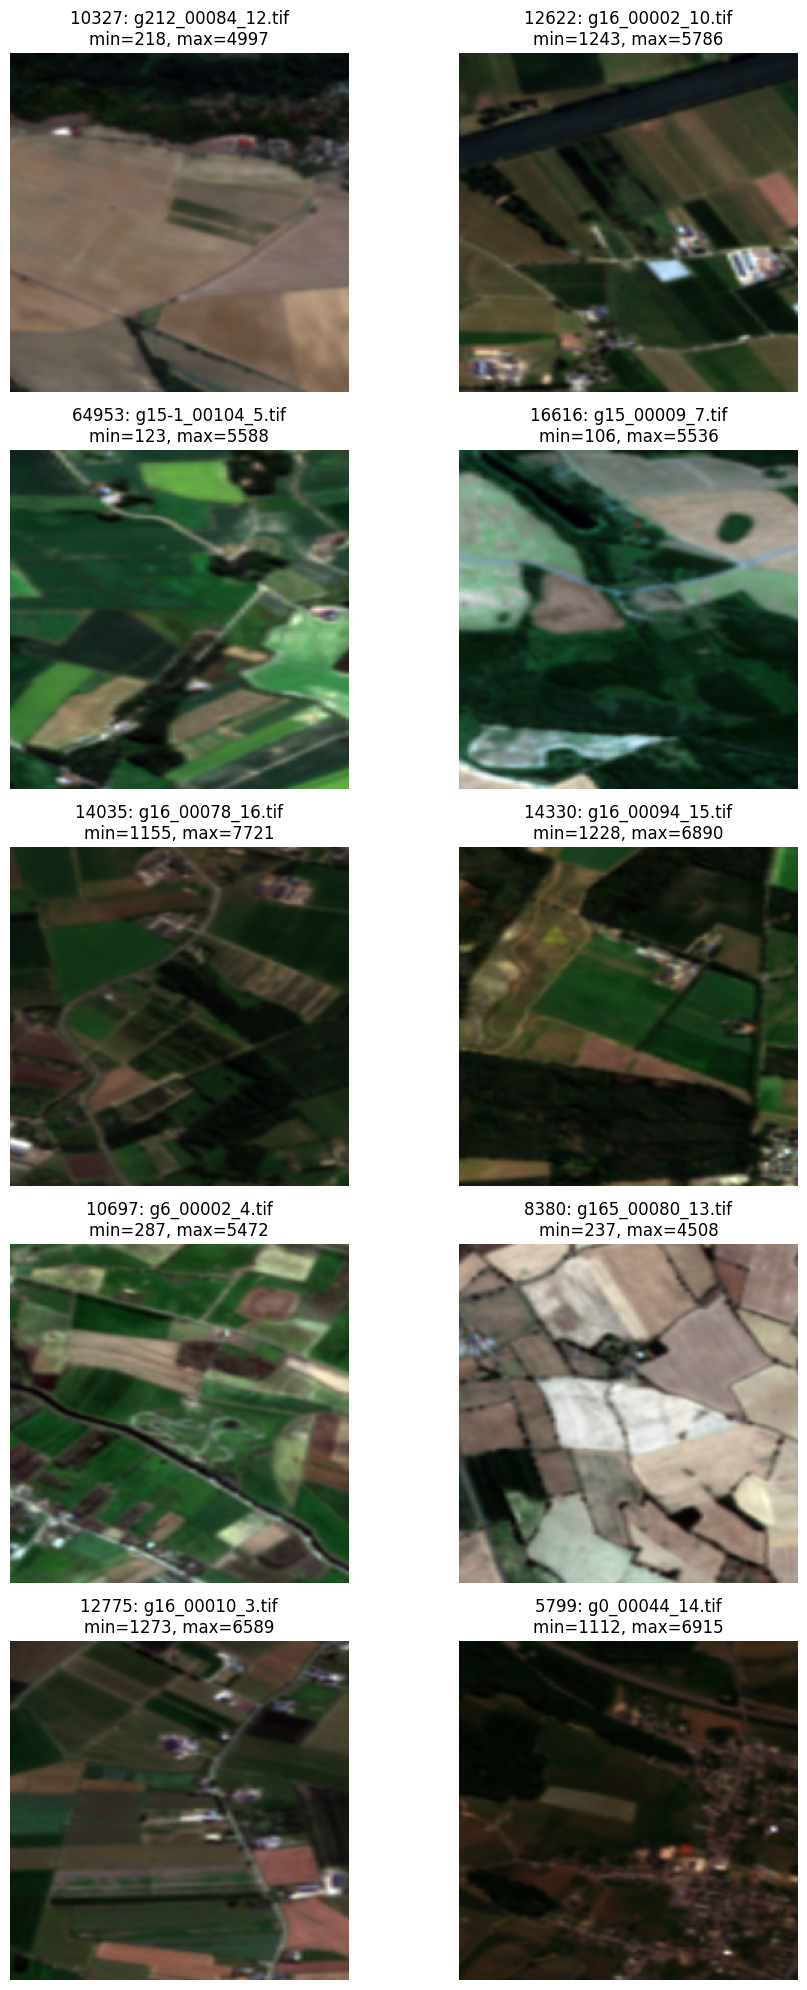

In [21]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for ax, img, row in zip(axs.ravel(), imgs, inf_catalog.itertuples()):
    # Compute per-band min and max
    mins = img.min(axis=(1, 2))
    maxs = img.max(axis=(1, 2))
    # Rescale each band
    img_rescale = np.stack([(b - mins[i]) / (maxs[i] - mins[i] + 1e-8) 
                            for i, b in enumerate(img)], axis=0)
    # Show as RGB if at least 3 bands, else show first band
    if img_rescale.shape[0] >= 3:
        ax.imshow(np.transpose(img_rescale[:3], (1, 2, 0)))
    else:
        ax.imshow(img_rescale[0], cmap='gray')
    ax.set_title(
        f"{row.Index}: {os.path.basename(row.window_b)}\n"
        f"min={img.min()}, max={img.max()}"
    )
    ax.axis("off")
plt.tight_layout()

Random selection of 10 with seed 7 seems to give good mix of images with closely packed fields of reasonably small size. 

In [22]:
inf_catalog.to_csv("../data/ftw-inference-tester.csv", index=False)